In [124]:
import tables
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Database loading and basic inspection

In [39]:
# Load the HDF5 database file and pull out the *design* table
h5file = tables.open_file("../unitcelldb.h5", mode="r")
table = h5file.root.design

In [40]:
table

/design (Table(13028,)) 'Unit cell design'
  description := {
  "Emax": Float64Col(shape=(), dflt=0.0, pos=0),
  "EmaxDirection": Float64Col(shape=(3,), dflt=0.0, pos=1),
  "Emin": Float64Col(shape=(), dflt=0.0, pos=2),
  "EminDirection": Float64Col(shape=(3,), dflt=0.0, pos=3),
  "Gmax": Float64Col(shape=(), dflt=0.0, pos=4),
  "GmaxDirection": Float64Col(shape=(3,), dflt=0.0, pos=5),
  "GmaxNormal": Float64Col(shape=(3,), dflt=0.0, pos=6),
  "Gmin": Float64Col(shape=(), dflt=0.0, pos=7),
  "GminDirection": Float64Col(shape=(3,), dflt=0.0, pos=8),
  "GminNormal": Float64Col(shape=(3,), dflt=0.0, pos=9),
  "Kmax": Float64Col(shape=(), dflt=0.0, pos=10),
  "KmaxDirection": Float64Col(shape=(3,), dflt=0.0, pos=11),
  "Kmin": Float64Col(shape=(), dflt=0.0, pos=12),
  "KminDirection": Float64Col(shape=(3,), dflt=0.0, pos=13),
  "anisotropyIndex": Float64Col(shape=(), dflt=0.0, pos=14),
  "conductance": Float64Col(shape=(), dflt=0.0, pos=15),
  "date": Int16Col(shape=(6,), dflt=0, pos=16),


Pull out the set of unique unitcell definitions (which correspond to both the form and unitcell fields)

In [41]:
unitcells = set((form.decode(), unitcell.decode()) for form, unitcell in zip(table.col("form"), table.col("unitcell")))
unitcells

{('graph', 'Body centered cubic'),
 ('graph', 'Diamond'),
 ('graph', 'Face centered cubic'),
 ('graph', 'Fluorite'),
 ('graph', 'Hexagonal honeycomb'),
 ('graph', 'IsoTruss'),
 ('graph', 'Kelvin cell'),
 ('graph', 'Octet'),
 ('graph', 'Re-entrant'),
 ('graph', 'Re-entrant honeycomb'),
 ('graph', 'Simple cubic'),
 ('graph', 'Square honeycomb'),
 ('graph', 'Square honeycomb rotated'),
 ('graph', 'Triangular honeycomb'),
 ('graph', 'Triangular honeycomb rotated'),
 ('graph', 'Truncated cube'),
 ('graph', 'Truncated octahedron'),
 ('graph', 'Weaire-Phelan'),
 ('walledtpms', 'Diamond'),
 ('walledtpms', 'Gyroid'),
 ('walledtpms', 'IWP'),
 ('walledtpms', 'Lidinoid'),
 ('walledtpms', 'Neovius'),
 ('walledtpms', 'Schwarz'),
 ('walledtpms', 'SplitP')}

Plot select images of unitcells in the database that have unit aspect ratio (same width, length, and height).

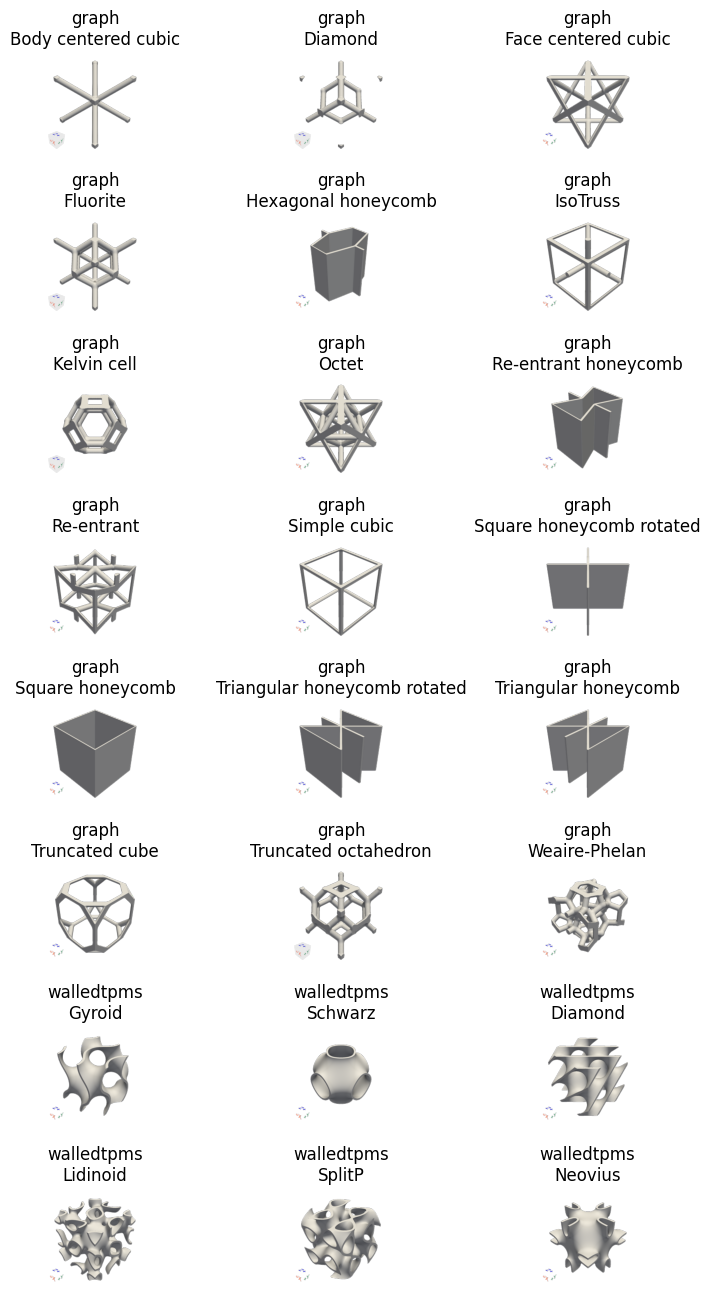

In [149]:
unitARImages = [(x['form'].decode(), x['unitcell'].decode(), x['image']) for x in table.iterrows() if x['length'] == 3. and x['width'] == 3. and x['height'] == 3. and x['thickness'] > 0.05]
N = len(unitARImages)
M = 3
fig, axs = plt.subplots(N//M, M)
fig.set_figheight(N*2//M)
fig.set_figwidth(M*3)
fig.subplots_adjust(hspace=0.7)
for ax, (form, unitcell, im) in zip(itertools.chain(*axs), unitARImages):
    ax.imshow(im)
    ax.set_title(f"{form}\n{unitcell}")
    ax.axis('off')
fig.savefig('unitcells.png')

# Advanced data manipulation

## Calculate mechanical engineering constants (Exx, Eyy, ...)

The orthotropic engineering constants are easiest to solve for using the compliance matrix form:

$$ \left[
    \begin{matrix}
        \epsilon_{xx} \\
        \epsilon_{yy} \\
        \epsilon_{zz} \\
        \epsilon_{xy} \\
        \epsilon_{yz} \\
        \epsilon_{xz}
    \end{matrix}
\right]
= 
\left[
    \begin{matrix}
        S_{11} & S_{12} & S_{13} & 0 & 0 & 0\\
        S_{12} & S_{22} & S_{13}& 0 & 0 & 0\\
        S_{13} & S_{12} & S_{33}& 0 & 0 & 0\\
        0 & 0 & 0 & S_{44} & 0 & 0\\
        0 & 0 & 0 & 0 & S_{55} & 0\\
        0 & 0 & 0 & 0 & 0 & S_{66}
    \end{matrix}
\right]
\left[
\begin{matrix}
    \sigma_{xx} \\
    \sigma_{yy} \\
    \sigma_{zz} \\
    \sigma_{xy} \\
    \sigma_{yz} \\
    \sigma_{xz}
\end{matrix}
\right] = 
\left[
    \begin{matrix}
        1/E_{xx} & -\nu_{yx}/E_{yy} & -\nu_{zx}/E_{zz} & 0 & 0 & 0\\
        -\nu_{xy}/E_{xx} & 1/E_{yy} & -\nu_{zy}/E_{zz} & 0 & 0 & 0\\
       -\nu_{xz}/E_{xx} & -\nu_{yz}/E_{yy} & 1/E_{zz} & 0 & 0 & 0\\
        0 & 0 & 0 & 1/2G_{xy} & 0 & 0\\
        0 & 0 & 0 & 0 & 1/2G_{yz} & 0\\
        0 & 0 & 0 & 0 & 0 & 1/2G_{xz}
    \end{matrix}
\right]
\left[
\begin{matrix}
    \sigma_{xx} \\
    \sigma_{yy} \\
    \sigma_{zz} \\
    \sigma_{xy} \\
    \sigma_{yz} \\
    \sigma_{xz}
\end{matrix}
\right]
$$

*NOTE*: The shear strains in this constitutive relationship correspond to the tensorial, rather than the engineering, form. 

In [152]:
def engineeringConstants(S):
    """ Calculate orthotropic engineering constants based on the compliance matrix """

     # Elastic and shear modulii can be solved for directly
    Exx, Eyy, Ezz = [1/S[i, i] for i in range(3)]
    Gxy, Gyz, Gxz = [1/S[i, i]/2 for i in range(3, 6)]

    # Solve for Poisson ratios
    nu12, nu23, nu13 = -S[1, 0]*Exx, -S[2, 1]*Eyy, -S[2, 0]*Exx
    nu21, nu32, nu31 = -S[0, 1]*Eyy, -S[1, 2]*Ezz, -S[0, 2]*Ezz

    return {"Exx": Exx, "Eyy": Eyy, "Ezz": Ezz, "Gxy": Gxy, "Gyz": Gyz, "Gxz": Gxz, "nu12": nu12, "nu21": nu21, "nu23": nu23, "nu32": nu32, "nu13": nu13, "nu31": nu31}
    

In [153]:
row = next(next(table.iterrows()))
for col in ['form', 'unitcell', 'length', 'width', 'height', 'thickness']:
    print(f"{col}: {row[col]}")
engineeringConstants(row['homogenizedCompliance'])

form: b'graph'
unitcell: b'Body centered cubic'
length: 1.0
width: 1.0
height: 1.25
thickness: 0.3


{'Exx': 0.09722241014380208,
 'Eyy': 0.09722705302025644,
 'Ezz': 0.11972555022041946,
 'Gxy': 0.0626943679108282,
 'Gyz': 0.07300589308307114,
 'Gxz': 0.07298494615580879,
 'nu12': 0.237062144889212,
 'nu21': 0.23707348088363164,
 'nu23': 0.31455456551461364,
 'nu32': 0.3873421152619583,
 'nu13': 0.31452322378383224,
 'nu31': 0.38732197887372183}

## Pull out a select subset of designs

With standard python comprehension

In [144]:
%%time
for row in table.iterrows():
    if (row['form'] == b'graph') and (row['unitcell'] == b'Body centered cubic') and (row['length'] > 4) and (row['width'] < 2):
        print("Row number: " + "; ".join([f"{col} = {row[col]}" for col in ['form', 'unitcell', 'length', 'width', 'height']]))

Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.25
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.5
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 2.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 4.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 5.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.25
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.5
Row number: form = b'graph'; unitcell = b'Body centered cub

With the in-kernel selection

In [132]:
%%time
for row in table.where("""(form == b'graph') & (unitcell == b'Body centered cubic') & (length > 4) & (width < 2)"""):
    print("Row number: " + "; ".join([f"{col} = {row[col]}" for col in ['form', 'unitcell', 'length', 'width', 'height']]))

Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.25
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 1.5
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 2.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 4.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.0; height = 5.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.0
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.25
Row number: form = b'graph'; unitcell = b'Body centered cubic'; length = 5.0; width = 1.25; height = 1.5
Row number: form = b'graph'; unitcell = b'Body centered cub